In [1]:
import os
import numpy as np
import glob
import random

from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Merge, BatchNormalization
from keras.layers.merge import Concatenate
from keras.callbacks import Callback, TensorBoard
from keras.models import Model
#from preprocessing import load_data, preprocess_data

from preprocessing import *
from crowdnet import *
from visualize import *


c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model_name = 'dcc_crowdnet'
model_path = os.path.expanduser(os.path.join('models', model_name))
data_path = os.path.expanduser(os.path.join('~/data', model_name))
weights_path = os.path.expanduser(os.path.join('~/models', model_name))

dataset_paths = ['dataset/UCF_CC_50']

slice_w = 256
slice_h = 256

patch_w = 225
patch_h = 225

net_density_h = 28
net_density_w = 28

In [3]:
#mean
VGG_ILSVRC_16_layers_mean = np.zeros((3, patch_h, patch_w), dtype='f4')
VGG_ILSVRC_16_layers_mean[0,:,:] = 103.939
VGG_ILSVRC_16_layers_mean[1,:,:] = 116.779
VGG_ILSVRC_16_layers_mean[2,:,:] = 123.68

In [4]:
# Positive image and ground truth loading
X_fs = []
Y_fs = []

for path in dataset_paths:
    images, gts, densities = load_images_and_gts(path)
    X_fs += images
    Y_fs += densities

dataset/UCF_CC_50\1.json
dataset/UCF_CC_50\1.json 149.34820247110426 984.2566389281416 (<class 'IndexError'>, IndexError('index 984 is out of bounds for axis 1 with size 984',), <traceback object at 0x00000123CE06F448>)
dataset/UCF_CC_50\1.json 533.5036428856122 984.2566389281419 (<class 'IndexError'>, IndexError('index 984 is out of bounds for axis 1 with size 984',), <traceback object at 0x00000123CE06F448>)
dataset/UCF_CC_50\10.json
dataset/UCF_CC_50\11.json
dataset/UCF_CC_50\12.json
dataset/UCF_CC_50\13.json
dataset/UCF_CC_50\14.json
dataset/UCF_CC_50\15.json
dataset/UCF_CC_50\16.json
dataset/UCF_CC_50\17.json
dataset/UCF_CC_50\17.json 395.77461139896366 1024.3341968911911 (<class 'IndexError'>, IndexError('index 1024 is out of bounds for axis 1 with size 1024',), <traceback object at 0x00000123CE06D5C8>)
dataset/UCF_CC_50\18.json
dataset/UCF_CC_50\19.json
dataset/UCF_CC_50\2.json
dataset/UCF_CC_50\20.json
dataset/UCF_CC_50\20.json 62.50520805512529 637.2357512953367 (<class 'Index

In [5]:
# Split test an train set
from sklearn.model_selection import train_test_split

# Train 80%, Test 20%
X_fs_train, X_fs_test, Y_fs_train, Y_fs_test = train_test_split(X_fs, Y_fs, test_size=0.2)

In [6]:
# FS: FULL SIZE
X_train, Y_train = X_fs_train, Y_fs_train
X_test, Y_test = X_fs_test, Y_fs_test

# DATA AUGMENTATION
print ('\nMultiscale pyramidal')
print ('TRAIN:')
X_train, Y_train = multiscale_pyramidal(X_train, Y_train)
print (len(X_train), len(Y_train))
print ('TEST:')
X_test, Y_test = multiscale_pyramidal(X_test, Y_test)
print (len(X_test), len(Y_test))

# PATCH SIZE
print ('\nGenerate slices')
print ('TRAIN:')
X_train, Y_train = generate_slices(X_train, Y_train, slice_w=patch_w, slice_h=patch_h, offset=8)
print (len(X_train), len(Y_train))
print ('TEST:')
X_test, Y_test = generate_slices(X_test, Y_test, slice_w=patch_w, slice_h=patch_h)
print (len(X_test), len(Y_test))

print ('\nFlip')
print ('TRAIN:')
X_train, Y_train = flip_slices(X_train, Y_train)
print (len(X_train), len(Y_train))
print ('TEST:')
X_test, Y_test = flip_slices(X_test, Y_test)
print (len(X_test), len(Y_test))

print ('\nSamples gt distribution correction')
print ('TRAIN:')
X_train, Y_train = samples_distribution(X_train, Y_train)
print (len(X_train), len(Y_train))

print ('\nShuffle')
print ('TRAIN:')
X_train, Y_train = shuffle_slices(X_train, Y_train)
print (len(X_train), len(Y_train))
print ('TEST:')
X_test, y_test = shuffle_slices(X_test, Y_test)
print (len(X_test), len(Y_test))


Multiscale pyramidal
TRAIN:
320 320
TEST:
80 80

Generate slices
TRAIN:
1067336 1067336
TEST:
682 682

Flip
TRAIN:
2134672 2134672
TEST:
1364 1364

Samples gt distribution correction
TRAIN:
35058 35058

Shuffle
TRAIN:
35058 35058
TEST:
1364 1364


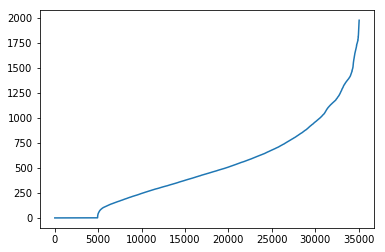

In [7]:
#Plot TRAIN samples distribution
from matplotlib import pyplot as plt

Y_train_sum = list(filter(lambda x: True, map(np.sum, Y_train)))
Y_train_sum.sort()
plt.plot(Y_train_sum)
plt.show()

In [8]:
# Train
print ('TRAIN:')
process_dump_to_hdf5data(X_train, Y_train, data_path, 'train', VGG_ILSVRC_16_layers_mean)
# Test
print ('TEST:')
process_dump_to_hdf5data(X_test, Y_test, data_path, 'test', VGG_ILSVRC_16_layers_mean)

TRAIN:
0 - 6999 / 35058
7000 - 13999 / 35058
14000 - 20999 / 35058
21000 - 27999 / 35058
28000 - 34999 / 35058
35000 - 35057 / 35058
TEST:
0 - 1363 / 1364


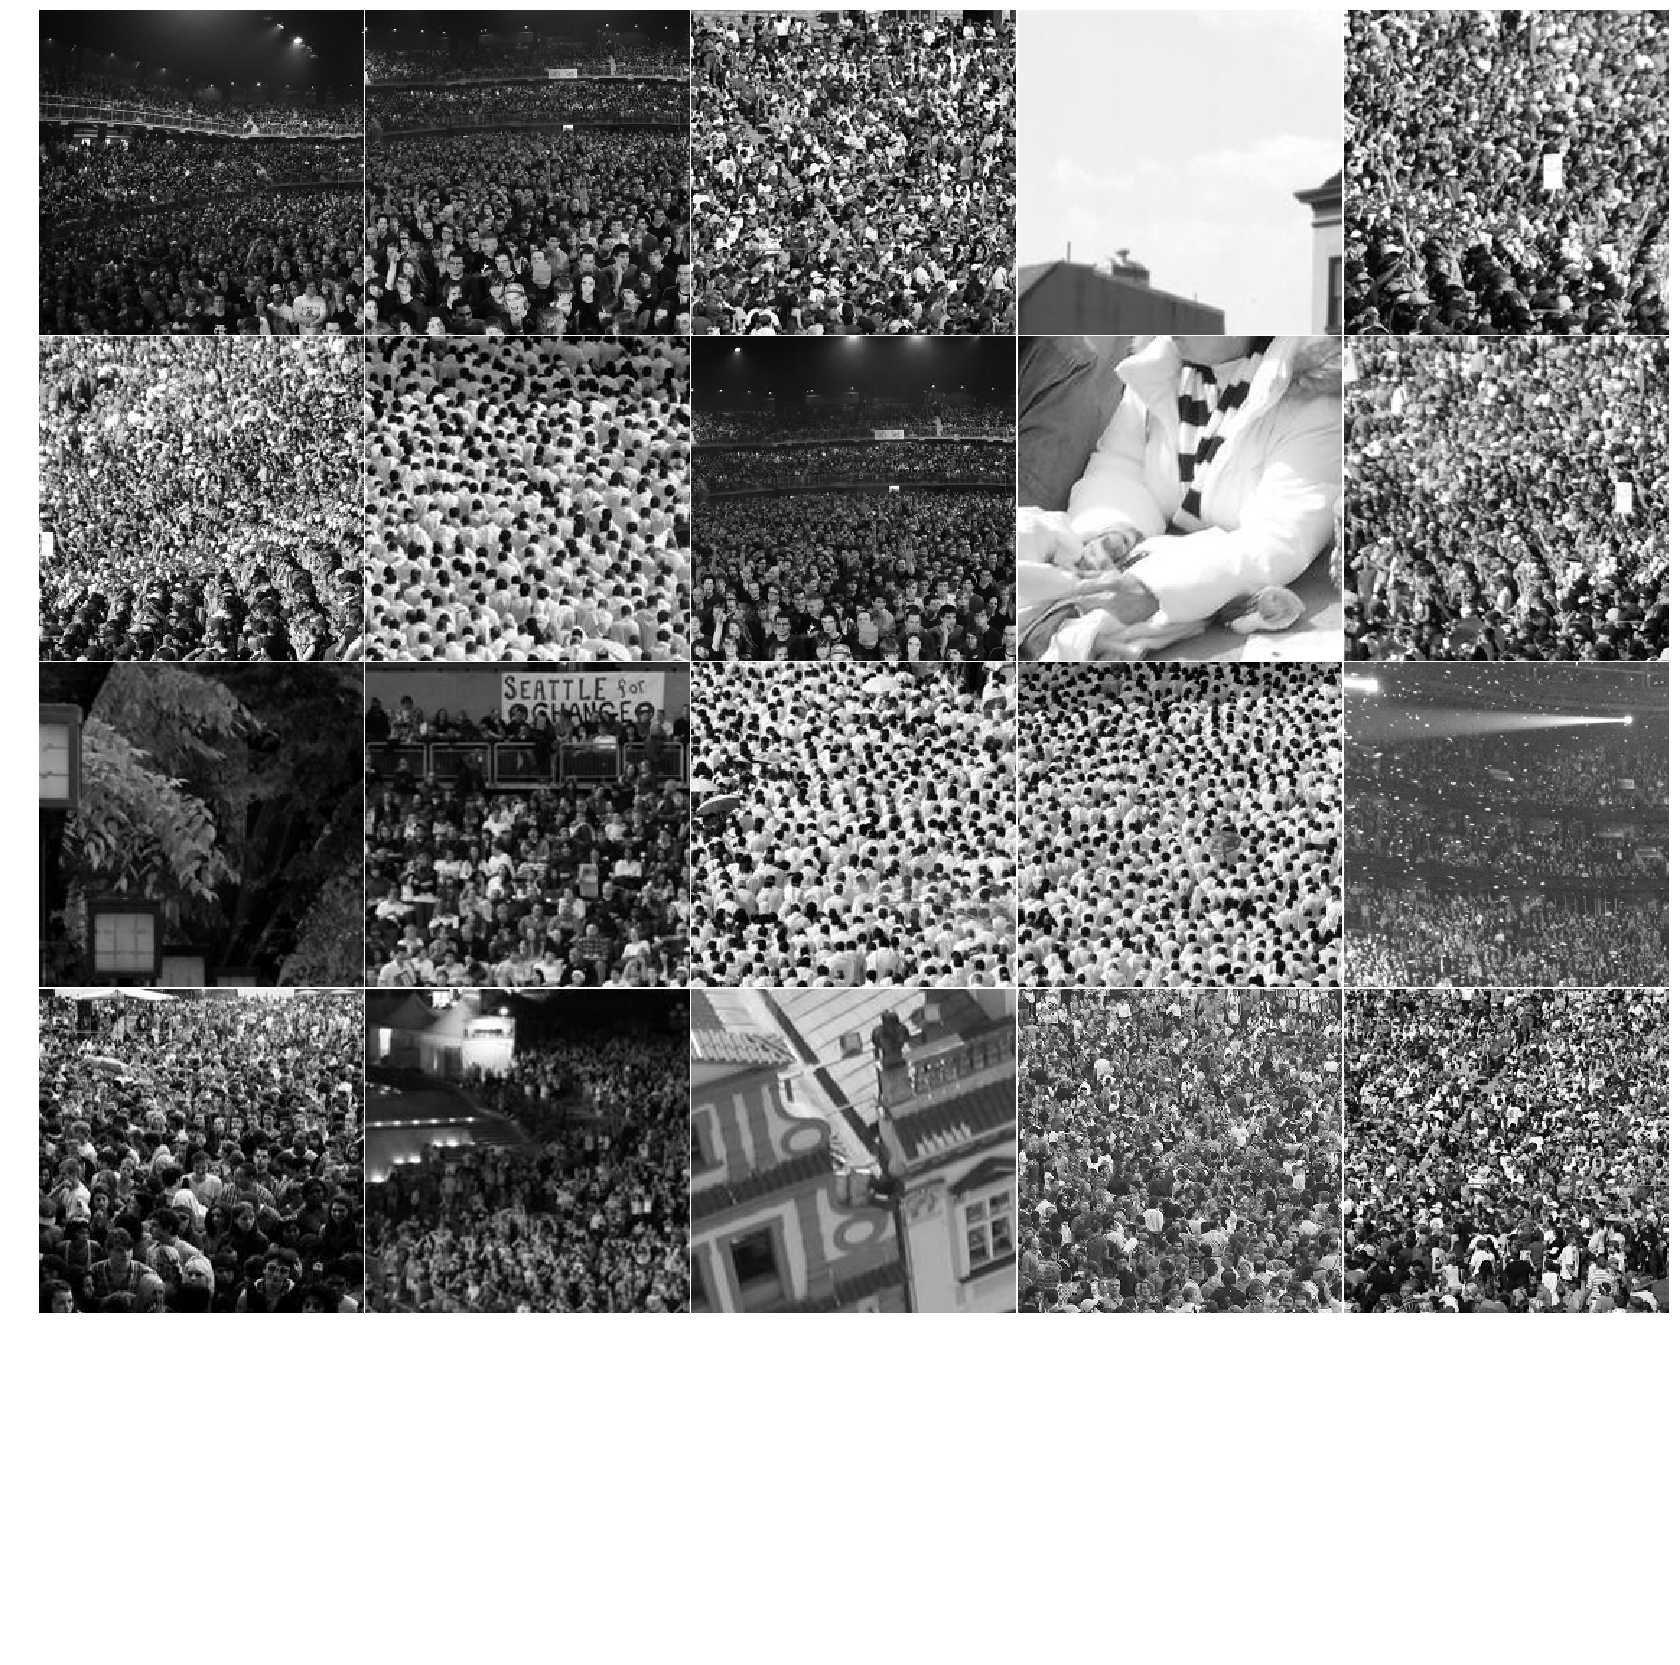

In [9]:
vis_square(list_to_np_array(X_train[:20]))

19192
559.3206


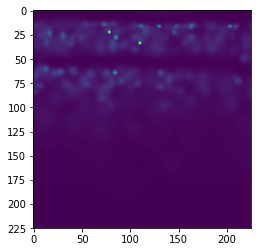

In [10]:
#visualize one random density
i = int(random.random()*len(Y_train))
print (i)
print (np.sum(Y_train[i]))
plt.imshow(np.fliplr(Y_train[i]))

In [11]:
print(X_train[1].shape)
print(Y_train[1].shape)

(225, 225, 3)
(225, 225)


In [12]:
batch_size=1
model = create_model(batch_size)

In [13]:
tensorboard_callback = TensorBoard(log_dir='./output', write_graph=True, write_images=True)

Instructions for updating:
Use the retry module or similar alternatives.


In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 225, 225, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 225, 225, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 225, 225, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 225, 225, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
model.fit(np.array(X_train), np.array(Y_train), epochs=100000, batch_size=batch_size)

ValueError: Error when checking target: expected conv2d_13 to have 4 dimensions, but got array with shape (35058, 225, 225)